# Load Library

In [237]:
import numpy as  np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm, trange
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

np.random.seed(0)
c_cmap = LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

# Configuration

In [238]:
CONFIG = {
    'THRESHOLD' : 0.5
}

# Generate Data

In [239]:
data, labels = make_blobs(n_samples=1500, centers=4, n_features=2, random_state=0)
labels = np.mod(labels, 2)
print(data.shape, labels.shape)

(1500, 2) (1500,)


# Plot Data

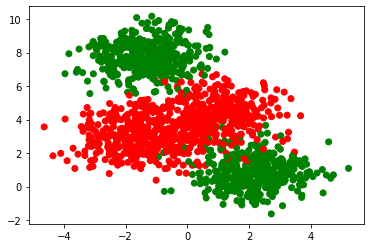

In [240]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=c_cmap)
plt.show()

# Train-Test Split

In [241]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, test_size=0.15, stratify=labels, random_state=10)

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(1275, 2) (1275,) (225, 2) (225,)


# Normalise Data

In [242]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Single Neuron

## Single Neuron Sigmoid Model Class

In [243]:
class SigmoidNeuron:
    def __init__(self):
        self.w = None
        self.b = None
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []

    def model(self, x):
        return 1. / (1. + np.exp(- (np.dot(self.w, x) + self.b)))

    def predict(self, X):
        return np.asarray([self.model(x) for x in X])

    def loss(self, Y, Y_pred):
        return log_loss(Y, Y_pred)

    def accuracy(self, Y, Y_pred):
        return accuracy_score(Y, (Y_pred >= CONFIG["THRESHOLD"]).astype(int))

    def grad_w(self, x, y, y_pred):
        return (y_pred - y) * x

    def grad_b(self, y, y_pred):
        return y_pred - y

    def fit(self, X_train, Y_train, X_val, Y_val, epochs=1, learning_rate=1, initialise=True):
        if initialise:
            self.w = np.random.randn(1, X_train.shape[1])
            self.b = 0

        for _ in trange(epochs, unit='epoch', desc='Epoch', ncols=80):
            Y_pred = self.predict(X_train)

            dw = 0
            db = 0
            for x, y, y_pred in zip(X_train, Y_train, Y_pred):
                dw += self.grad_w(x, y, y_pred)
                db += self.grad_b(y, y_pred)

            self.w -= (learning_rate * dw)
            self.b -= (learning_rate * db)

            Y_pred = self.predict(X_train)
            self.train_loss.append(self.loss(Y_train, Y_pred))
            self.train_accuracy.append(self.accuracy(Y_train, Y_pred))

            Y_val_pred = self.predict(X_val)
            self.val_loss.append(self.loss(Y_val, Y_val_pred))
            self.val_accuracy.append(self.accuracy(Y_val, Y_val_pred))

        print('Final Train Loss:', self.train_loss[-1])
        print('Final Validation Loss:', self.val_loss[-1])
        print('Final Train Accuracy:', self.train_accuracy[-1])
        print('Final Validation Accuracy:', self.val_accuracy[-1])

    def plot_graphs(self):
        plt.plot(self.train_loss, label='Train Loss')
        plt.plot(self.val_loss, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss Error')
        plt.legend()
        plt.show()

        plt.plot(self.train_accuracy, label='Train Accuracy')
        plt.plot(self.val_accuracy, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def evalute(self, X_test, Y_test):
        Y_test_pred = self.predict(X_test)
        print('Test Accuracy:', self.accuracy(Y_test, Y_test_pred))

## Train Model

Epoch: 100%|███████████████████████████████| 100/100 [00:04<00:00, 21.39epoch/s]


Final Train Loss: 0.628027343738937
Final Validation Loss: 0.6342583724645013
Final Train Accuracy: 0.6329411764705882
Final Validation Accuracy: 0.6177777777777778


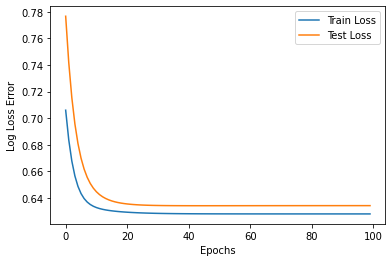

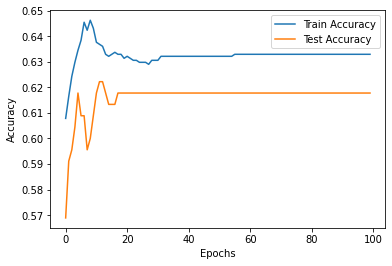

In [244]:
model = SigmoidNeuron()
model.fit(X_train, Y_train, X_val, Y_val, epochs=100, learning_rate=0.0005)
model.plot_graphs()

## Compare Prediction with True Output

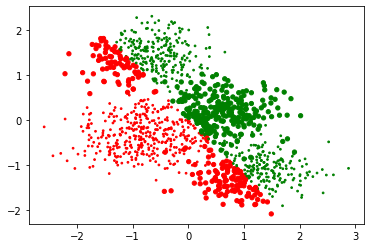

In [245]:
Y_train_pred = (model.predict(X_train) >= CONFIG["THRESHOLD"]).astype(int).ravel()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train_pred, s=15*(np.abs(Y_train_pred - Y_train)+0.2), cmap=c_cmap)
plt.show()

# Deep Neural Network

## Model Class

In [246]:
class FFSNNetwork:
    def __init__(self, n_inputs, hidden_sizes=[2]):
        self.nx = n_inputs
        self.ny = 1
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny]

        self.W = {}
        self.B = {}
        for i in range(self.nh + 1):
            self.W[i + 1] = np.random.randn(self.sizes[i], self.sizes[i
                    + 1])
            self.B[i + 1] = np.zeros((1, self.sizes[i + 1]))

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def forward_pass(self, x):
        self.A = {}
        self.H = {}
        self.H[0] = x.reshape(1, -1)
        for i in range(self.nh + 1):
            self.A[i + 1] = np.matmul(self.H[i], self.W[i + 1]) \
                + self.B[i + 1]
            self.H[i + 1] = self.sigmoid(self.A[i + 1])
        return self.H[self.nh + 1]

    def grad_sigmoid(self, x):
        return x * (1 - x)

    def grad(self, x, y):
        self.forward_pass(x)
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        L = self.nh + 1
        self.dA[L] = self.H[L] - y
        for k in range(L, 0, -1):
            self.dW[k] = np.matmul(self.H[k - 1].T, self.dA[k])
            self.dB[k] = self.dA[k]
            self.dH[k - 1] = np.matmul(self.dA[k], self.W[k].T)
            self.dA[k - 1] = np.multiply(self.dH[k - 1],
                    self.grad_sigmoid(self.H[k - 1]))

    def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
        # initialise w, b
        if initialise:
            for i in range(self.nh + 1):
                self.W[i + 1] = np.random.randn(self.sizes[i],
                        self.sizes[i + 1])
                self.B[i + 1] = np.zeros((1, self.sizes[i + 1]))

        if display_loss:
            loss = {}

        for e in tqdm(range(epochs), total=epochs, unit='epoch'):
            dW = {}
            dB = {}
            for i in range(self.nh + 1):
                dW[i + 1] = np.zeros((self.sizes[i], self.sizes[i + 1]))
                dB[i + 1] = np.zeros((1, self.sizes[i + 1]))
            for (x, y) in zip(X, Y):
                self.grad(x, y)
                for i in range(self.nh + 1):
                    dW[i + 1] += self.dW[i + 1]
                    dB[i + 1] += self.dB[i + 1]

            m = X.shape[1]
            for i in range(self.nh + 1):
                self.W[i + 1] -= learning_rate * dW[i + 1] / m
                self.B[i + 1] -= learning_rate * dB[i + 1] / m

            if display_loss:
                Y_pred = self.predict(X)
                loss[e] = mean_squared_error(Y_pred, Y)

        if display_loss:
            plt.plot(loss.values())
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            plt.show()

    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()


## Train Model

100%|██████████| 1000/1000 [02:19<00:00,  7.16epoch/s]


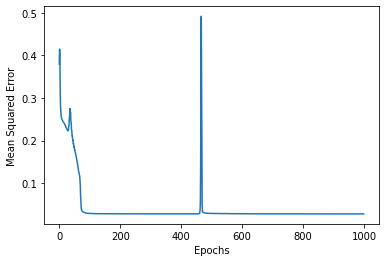

In [247]:
ffsnn = FFSNNetwork(2, [2, 3])
ffsnn.fit(X_train, Y_train, epochs=1000, learning_rate=.01, display_loss=True)

## Compare Output with True Output

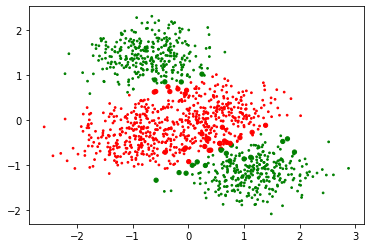

In [249]:
Y_train_pred = (ffsnn.predict(X_train) >= CONFIG["THRESHOLD"]).astype(int).ravel()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train_pred, s=15*(np.abs(Y_train_pred - Y_train)+0.2), cmap=c_cmap)
plt.show()